## Joseph EL KETTANEH - M1 SD
# TP3 Apprentissage Automatique 2 
# Régression logistique multiclasse

In [1]:
import numpy as np
import pandas as pd

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

#To plot the graph embedded in the notebook
%matplotlib inline
import sklearn.datasets
from numpy import array
from numpy import argmax
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from IPython.display import Image
#imports from sklearn library

from sklearn import datasets
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay

from scipy.optimize import line_search
import sys
np.set_printoptions(threshold=sys.maxsize)


### One-hot-encoding

En machine learning pour représenter un vecteur de données catégoriques, on utilise le one-hot encoding.

Par exemple
$ y = \left(\begin{array}{cc} 
1 \\
1 \\
2 \\
3 \\
2 \\
\end{array}\right) $

devient:

 y_one = $ \left(\begin{array}{cc} 
1. & 0. & 0.\\
1. & 0. & 0.\\
0. & 1. & 0.\\
0. & 0. & 1.\\
0. & 1. & 0.\\
\end{array}\right) $


In [2]:
def oneHotEncodage(y,n_class):
    y_one = np.eye(n_class)[np.array(y).reshape(-1)]
    y_one = y_one.reshape(list(y.shape)+[n_class])
    return y_one

### Softmax

On veut convertir le vecteur de logits **z**, en un **vecteur de probabilité**.

Pour cela on définit la **fonction softmax**:

$$ {p_x}^k = softmax(z)_k = \frac{exp(z_k)}{\sum_{\substack{1<j<K}} exp(z_j)} $$

Intuitivement, pour un logit de z, $z_k$, on prend l'exponentielle de cette valeur et on la divise par la somme des exponentielles de chaque logit du vecteur **z**. On obtient  ${p_x}^k$ la probabilité que l'exemple **x** appartienne à la classe **k**.

In [3]:
def softmax(z):
    z -= np.max(z)
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)

### Probabilité
Permet de prédire la probabilité de chaque classe pour chaque exemple du dataset fourni.

Etant donnée les probabilités des classes pour chaque échantillon, on doit choisir la classe avec le max de probabilité.


In [4]:
def get_prob_pred(X,w):
    z=X@w.T
    probs=softmax(z)
    preds=np.zeros(len(probs))
    for i in range(len(probs)):
        preds[i]=np.where(probs[i]==[np.amax(probs[i])])[0][0]
    return probs , preds

### Fonction de coût

On réfère aux probabilités trouvées par la fonction softmax comme $p$, où $p$ est la probabilité d'une classe $c$.

Le coût total est la moyenne des coût de tous les échantillons

$$L = -\frac{1}{n} \sum\limits_{i=1}^{n}\sum\limits_{j=1}^{C} y_{i,j}\log(p_{i,j})$$

- $y$ : les probabilités réelles (1 ou 0) de chaque échantillon de chaque classe (L)
- $n$ : le nombre d’instances d’apprentissage
- $C$ : le nombre de classes
- $p_{i,k}$ est la probabilité de l’instance i d’appartenir à la classe k exprimé par la fonction softmax

$$ p_{i,k} = softmax(z)_k = \frac{exp(z_{i,j})}{\sum\limits_{k=1}^{C} exp(z_{i,k})} $$



###  Calcul des gradients


$$\frac{\partial L}{\partial W_{k}} = -\frac{1}{n} \sum\limits_{i=1}^{n}\sum\limits_{j=1}^{C}y_{i,j} \frac{1}{p_{i,j}} \frac{\partial p_{i,j}}{\partial z_{i,k}} \frac{\partial z_{i,k}}{\partial W_{k}} $$

La dérivé de $\frac{\partial z_{i,k}}{\partial W_{k}}$

$$
\frac{\partial z_{i,k}}{\partial W_{k}} = \frac{\partial}{\partial W_{k}} \sum_i W_{k} X_{i}+b
                                      = X_{i}
$$

La dérivé de $\frac{\partial p_{i,j}}{\partial z_{i,k}}$

On doit dérivé pour deux cas différent, soit $j=k$, soit $j \neq k$:
- Si $j=k$

$$
\begin{equation} \label{eq:jeqk}
\frac{\partial p_{i,k}}{\partial z_{i,k}} = \frac{\partial}{\partial z_{i,k}}\frac{\exp(z_{i,k})}{\sum_k\exp(z_k)} 
\\ = \frac{\exp(z_{i,k})\sum_k\exp(z_k) - \exp(z_{i,k})\exp(y_{i,k})}{\left(\sum_k\exp(z_k)\right)^2}
\\ = \frac{\exp(z_{i,k})}{\sum_k\exp(z_k)}\left(1 - \frac{\exp(z_{i,k})}{\sum_k\exp(z_k) }\right)\\
\\ = p_{i,k}(1 - p_{i,k})
\end{equation}
$$

- Si $j \neq k$
$$
\begin{equation} \label{eq:jneqk}
\frac{\partial p_{i,j}}{\partial z_{i,k}} = \frac{\partial}{\partial z_{i,j}}\frac{\exp(z_{i,j})}{\sum_k\exp(z_k)}
 \\ = 0 - \frac{\exp(z_{i,j})\exp(z_{i,k})}{\left(\sum_k\exp(z_k)\right)^2}
 \\ = - \frac{\exp(z_{i,j})}{\sum_k\exp(z_k)}\frac{\exp(z_{i,k})}{\sum_k\exp(z_k)}\\
 \\ = - p_{i,j} p_{i,k}
\end{equation}
$$

$ => $
$$ (1) = p_{i,k}(1 - p_{i,k})$$ et $$(2) = - p_{i,j} p_{i,k} $$

On avait 

$$\frac{\partial L}{\partial z_{i,j}} = \frac{\partial L}{\partial p_{i,j}}\frac{\partial p_{i,k}}{\partial z_{i,k}}$$


Donc, pour le cas $j=k$, on a

$$\frac{\partial L}{\partial z_{i,j}} = -\frac{1}{p_{i,k}}p_{i,k}(1 - p_{i,k}) = p_{i,k} - 1$$

Et pour le cas $j\neq k$, on a 

$$\frac{\partial L}{\partial y_{i,j}} = -\frac{1}{p_{i,k}}(- p_{i,k}p_{i,j}) = p_{i,j}$$

Autrement dit, si $j=j$, on soustrait 1 à $p_{i,j}$ sinon 0. On peut donc combiner les deux cas en soustrayant $y_{n,j}$!

$$\frac{\partial L}{\partial z_{i,j}} = p_{i,j} - y_{n,j}$$

$ => $
$$ \nabla L = \frac{\partial L}{\partial W_{k}} = -\frac{1}{n} \sum\limits_{i=1}^{n}\sum\limits_{j=1}^{C}y_{i,j} \frac{1}{p_{i,j}} \frac{\partial p_{i,j}}{\partial z_{i,k}} \frac{\partial z_{i,k}}{\partial W_{k}} $$
$ => $

On se retrouve avec 

$$
\nabla_{W_k} L = -\frac{1}{n} \sum\limits_{i=1}^{n} x_i(y_{i,k} - p_{i,k})
$$


  On ajoute un terme de régularisation 𝑙2 à la fonction de perte et essaye de minimiser la fonction combinée. En fait, la valeur par défaut de scikit-learn utilise des pénalités 𝑙2. La régularisation 𝑙1 est également très couramment utilisée. Ici, on utilise la régularisation 𝑙2.


In [5]:
def get_loss_grad(w,X,y,lam,n_class):
    #y_mat = oneHotEncodage(y,n_class) # convert the integer class coding into a one hot representation
    scores = X@w.T 
    p = softmax(scores) 
    loss=0
    grad=np.zeros(shape=(10,X.shape[1]))
    loss = (-1 / n_class) * np.sum(y * np.log(p +0.00001)) + (lam/2)*np.sum(w*w)
    grad=(-1 / n_class) * np.dot((y-p).T,X) + lam*w
    
          
    return loss , grad 

### Optimiser les paramètres W 
La mise à jour de $W$ se calcule selon

$$W^{t+1} \leftarrow W^t - \lambda \left(h(X_n)-t_n)\right)^TX_n $$
$$ => $$
$$ W^{t+1} \leftarrow W^t - \lambda\nabla $$

In [6]:
def CalculateW(X,y_mat,lam,nb_iter,n_class):
    w=np.zeros(shape=(n_class,X.shape[1]+1))
    X1= np.ones((X.shape[0],X.shape[1]+1))
    X1[:,:-1] = X
    loss=np.zeros(nb_iter)
    result = []
    for i in range(nb_iter):  
        loss[i],grad=get_loss_grad(w,X1,y_mat,lam,n_class)
        w = w - (lam*grad)
        #result.append(line_search(loss[i], grad, w[i], lam))
        
        
    #loss[i],grad=get_loss_grad(w,X1,y_mat,lam,n_class)
    
    probs,preds=get_prob_pred(X1,w) 
    return w,loss,probs,preds
        

### Taux de bonne classification

In [7]:
def taux_de_classification(y_mat, y_pred):
        return np.mean(y_mat== y_pred)

In [8]:
n_class = 10
X,y = load_digits(n_class=n_class , return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)
y_mat = oneHotEncodage(y_train,n_class)

### Apprentissage pour les données de train avec Lam = 0.001

In [9]:
W,loss,y_probs,y_preds=CalculateW(X_train,y_mat,0.001,1000,n_class)
erreur = taux_de_classification(y_train,y_preds)
print("\n\n En Apprentissage on a obtenue: \n\n\n - un taux de bonne classification = {} \n\n\n - erreur = {} \n\n\n Ce qui est bien en apprentissage mais peut poser de sur-apprentissage \n\n ".format(erreur,1-erreur))



 En Apprentissage on a obtenue: 


 - un taux de bonne classification = 1.0 


 - erreur = 0.0 


 Ce qui est bien en apprentissage mais peut poser de sur-apprentissage 

 


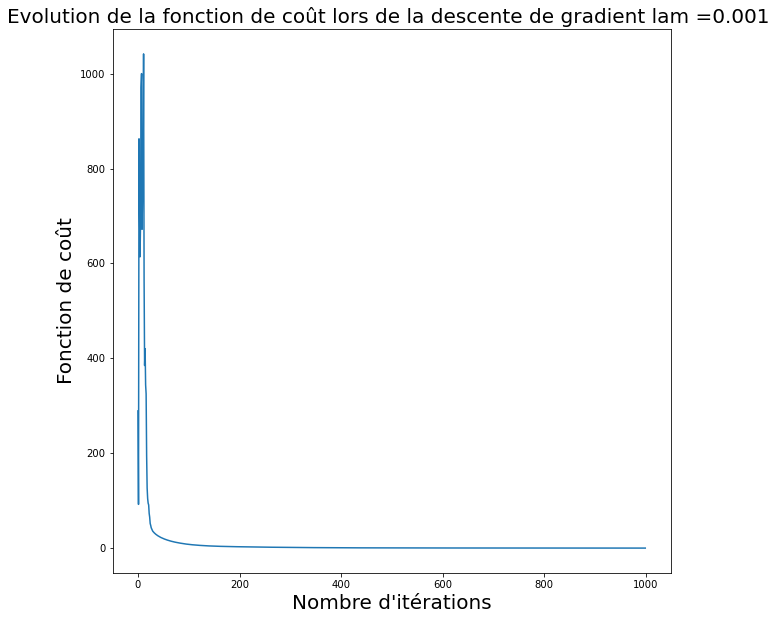

In [10]:
fig = plt.figure(figsize=(10,10))
plt.plot(loss)
plt.title("Evolution de la fonction de coût lors de la descente de gradient lam =0.001 ",fontsize = 20)
plt.xlabel("Nombre d\'itérations",fontsize = 20)
plt.ylabel("Fonction de coût",fontsize = 20)
plt.show()

    J'essaie mon modèle sur le jeu de données de load_digits. Je fais l'apprentissage sur le modèle et je trace la fonction de coût en fonction Nombre d'itérations, je vois que notre fonction de cout diminue avec les iterations mais la courbe n'est pas convexe. Lorsque je regarde la prédiction des données, je vois que l'algorithme prédit correctement tous les classes.

In [11]:
y_train == y_preds

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Apprentissage pour les données de train avec Lam = 0.00001

In [12]:
W,loss,y_probs,y_preds=CalculateW(X_train,y_mat,0.00001,1000,n_class)
erreur = taux_de_classification(y_train,y_preds)
print("\n\n En Apprentissage on a obtenue: \n\n\n - un taux de bonne classification = {} \n\n\n - erreur = {} \n\n\n Ce qui est bien en apprentissage\n\n ".format(erreur,1-erreur))



 En Apprentissage on a obtenue: 


 - un taux de bonne classification = 0.9721559268098647 


 - erreur = 0.027844073190135266 


 Ce qui est bien en apprentissage

 


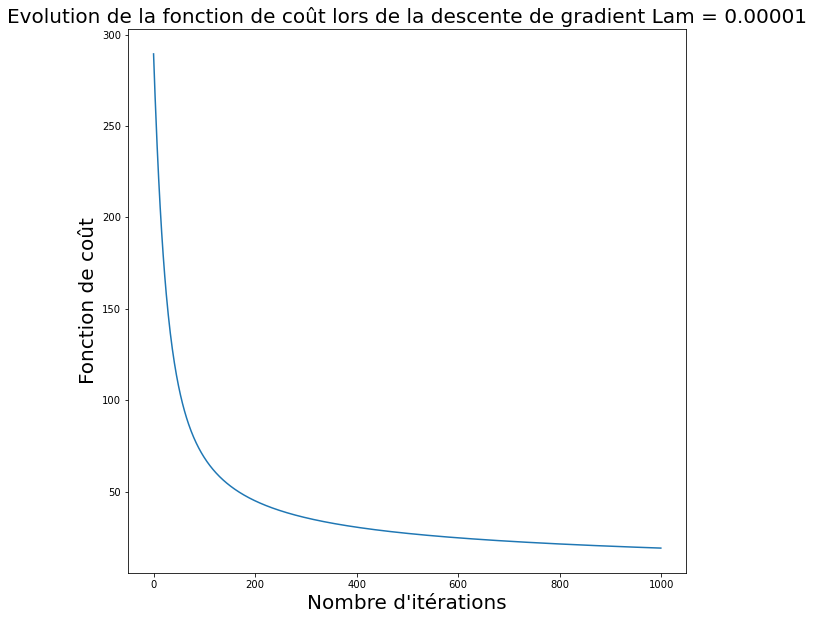

In [13]:
fig = plt.figure(figsize=(10,10))
plt.plot(loss)
plt.title("Evolution de la fonction de coût lors de la descente de gradient Lam = 0.00001",fontsize = 20)
plt.xlabel("Nombre d\'itérations",fontsize = 20)
plt.ylabel("Fonction de coût",fontsize = 20)
plt.show()

        J'essaie mon modèle sur le jeu de données de load_digits. Je fais l'apprentissage sur le modèle et je trace la fonction de coût en fonction Nombre d'itérations, je vois que notre fonction de cout diminue avec les iterations avec une courbe bien convexe. Lorsque je regarde la prédiction des données, je vois que l'algorithme prédit correctement la plupart des classes.

In [14]:
y_train == y_preds

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,